#### pix2pix model. applied on digital light microscope.
#### input: images: (t, H, W, C) | masks: (t, H, W, C). Outputs: (t, H, W, C). C=3

In [1]:
# detect the GPU status

import tensorflow as tf

print(tf.__version__)

from tensorflow.python.client import device_lib

local_device_protos = device_lib.list_local_devices()

[print(x) for x in local_device_protos if x.device_type == 'GPU']

2.6.2
name: "/device:GPU:0"
device_type: "GPU"
memory_limit: 32503955456
locality {
  bus_id: 1
  links {
  }
}
incarnation: 3362765028973253838
physical_device_desc: "device: 0, name: Tesla V100-SXM2-32GB, pci bus id: 0000:61:00.0, compute capability: 7.0"



2022-06-22 00:18:27.536767: I tensorflow/core/platform/cpu_feature_guard.cc:142] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 AVX512F FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.


[None]

2022-06-22 00:18:34.540018: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1510] Created device /device:GPU:0 with 30998 MB memory:  -> device: 0, name: Tesla V100-SXM2-32GB, pci bus id: 0000:61:00.0, compute capability: 7.0


In [2]:
# define if the documenting process should go on

DOCUMENT = False
TRAIN = 300 # training epochs num

In [3]:
# neptune document

import neptune.new as neptune
from neptune.new.integrations.tensorflow_keras import NeptuneCallback

if DOCUMENT:

    run = neptune.init(
        project="leeleeroy/LM-2D-GAN",
        api_token="eyJhcGlfYWRkcmVzcyI6Imh0dHBzOi8vYXBwLm5lcHR1bmUuYWkiLCJhcGlfdXJsIjoiaHR0cHM6Ly9hcHAubmVwdHVuZS5haSIsImFwaV9rZXkiOiI3YjVjOGVmZi04MjA4LTQ4N2QtOWIzYy05M2YyZWI1NzY3MmEifQ==",
        name = "CycleGAN_vanilla",
    ) # necessary credentials, the name could be used to reproduce the results 

    # for callbacks in training
    neptune_cbk = NeptuneCallback(run=run, base_namespace='metrics')  # neptune for the training process
    
    # neptune document the hyper param.

    PARAMS = {
              "optimizer": {"learning_rate": 0.001, "beta_1":0.9,"optimizer": "Adam"},
              'epochs': TRAIN,
              'batch_size':8}

    # log hyper-parameters
    run['hyper-parameters'] = PARAMS
    run["sys/tags"].add(["vanilla", "val", "binary", "epochs:300"])


#### Load in the data

In [4]:
# data loading 

import os
import numpy as np
import matplotlib.pyplot as plt
from scipy import ndimage
import os
import pandas as pd
import random

In [5]:
# visualization for two images

def subShow(IMG1, IMG2):
    plt.figure()
    plt.subplot(1,2,1)
    plt.imshow(IMG1, cmap='gray')
    plt.subplot(1,2,2)
    plt.imshow(IMG2, cmap='gray')
    plt.show()

In [6]:
PATH = '/bigdata/casus/MLID/RuiLi/Data/LM/zebrafish_partial_15/'

Mask = np.load(PATH + 'biMasks15.npy')
IMG = np.load(PATH + 'rawGray15.npy')

Mask = Mask.reshape(-1, 1040, 1392)  # flatten into images 
IMG = IMG.reshape(-1, 1040, 1392)

Mask = Mask[...,176:(176+Mask.shape[1])]  # crop for later scaling
IMG = IMG[...,176:(176+IMG.shape[1])]

print('Mask info: ', Mask.shape, Mask.dtype)
print('Image info: ', IMG.shape, IMG.dtype)

Mask info:  (300, 1040, 1040) uint8
Image info:  (300, 1040, 1040) uint8


In [7]:
# resize the images

from skimage.transform import resize

SIZE = [256, 256]
totalIMG = Mask.shape[0]
numIMG = 250

smallIMG = resize(IMG[:numIMG,...], (numIMG,SIZE[0],SIZE[1]), anti_aliasing=True)
smallIMG = np.interp(smallIMG, (smallIMG.min(), smallIMG.max()), (-1, 1))  # rescale the img into [-1, 1] for cycleGAN

smallMask = resize(Mask[:numIMG,...].astype(bool), (numIMG,SIZE[0],SIZE[1]), anti_aliasing=False)
smallMask = smallMask.astype(int)
smallMask = np.interp(smallMask, (smallMask.min(), smallMask.max()), (-1, 1))

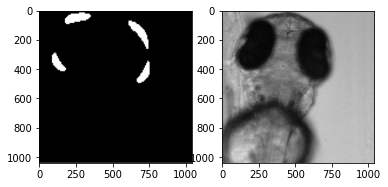

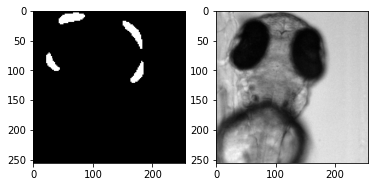

In [8]:
# sanity check

NUM = 100

subShow(Mask[NUM,...], IMG[NUM,...])

subShow(smallMask[NUM,...], smallIMG[NUM,...])

In [9]:
# patchify the images
from patchify import patchify, unpatchify

def rawPatch(imageStack,patchPara):
    all_img_patches = []

    for img in range(imageStack.shape[0]):
        large_image = imageStack[img]

        patches_img = patchify(large_image, (patchPara['x'],patchPara['y']), step=patchPara['step'])  # no overlap

        for i in range(patches_img.shape[0]):
            for j in range(patches_img.shape[1]):

                single_patch_img = patches_img[i,j,:,:]
                # transform the image if the type is not correct
                if single_patch_img.dtype == 'uint8':
                    single_patch_img = (single_patch_img.astype('float32')) / 255.  # remember to standarize into 0-1
                    
                all_img_patches.append(single_patch_img)
    
    return all_img_patches, patches_img.shape

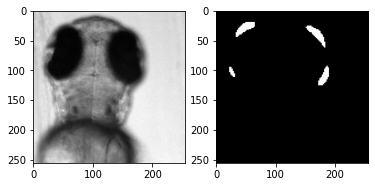

img: (250, 256, 256) float64
mask: (250, 256, 256) float64
img range: 1.0 -1.0
mask range: 1.0 -1.0


In [10]:
# sanity check for the resized data

subShow(smallIMG[0,...], smallMask[0,...])

print('img:',smallIMG.shape, smallIMG.dtype)
print('mask:',smallMask.shape, smallMask.dtype)

print('img range:', np.max(smallIMG), np.min(smallIMG))
print('mask range:', np.max(smallMask), np.min(smallMask))

In [11]:
# preporcessing the data into patches and change into 3 channels

# train dataset
patchPara = {'x': 256, 'y': 256, 'step':256}

X_patches, _ =  rawPatch(smallIMG, patchPara); X_patches = np.stack((X_patches,)*3, axis=-1)
Y_masks, _ = rawPatch(smallMask, patchPara); Y_masks = np.stack((Y_masks,)*3, axis=-1) #Y_masks = np.expand_dims(Y_masks, -1)

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


img: (250, 256, 256, 3)
masks: (250, 256, 256, 3)


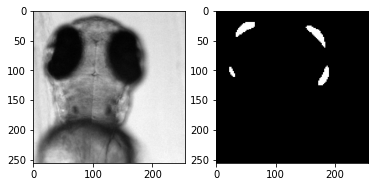

In [12]:
# sanity check on one layer
print('img:', X_patches.shape)
print('masks:', Y_masks.shape)

subShow(X_patches[0,:,:,0], Y_masks[0,...])

In [13]:
# check the data properties

print('patches shape:',X_patches.shape, X_patches.dtype)
print('mask shape:',Y_masks.shape, Y_masks.dtype)
print(np.max(Y_masks[0,...]), np.min(Y_masks[0,...]))
print(np.max(X_patches[0,...]), np.min(X_patches[0,...]))

patches shape: (250, 256, 256, 3) float64
mask shape: (250, 256, 256, 3) float64
1.0 -1.0
-0.18901383526725068 -0.9941123068768966


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


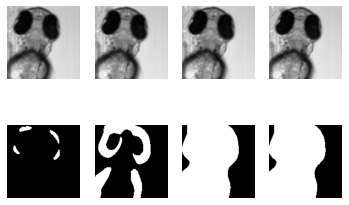

In [14]:
#  sanity check for the mask and images

startNum = 100
n_samples = 4

for i in range(n_samples):
    plt.subplot(2, n_samples, 1+i)
    plt.axis('off')
    plt.imshow(X_patches[int(i+startNum),:,:,0], cmap='gray')  # only visualize one channel
    
for i in range(n_samples):
    plt.subplot(2, n_samples, 1+n_samples+i)
    plt.axis('off')
    plt.imshow(Y_masks[int(i+startNum)], cmap='gray')    
plt.show()

### Prepare the model

In [15]:
import numpy as np
from numpy.random import randint

from tensorflow.keras.optimizers import Adam
from keras.initializers import RandomNormal  #  for normalization
import tensorflow.keras as k
from tensorflow.keras.utils import plot_model  # visualize the model

import matplotlib.pyplot as plt

In [16]:
# Discriminator

# define generator, discriminator, gan
# use defination wihout sequential, since there are several inputs
# pix2pix is a conditiional GAN with two inputs: image, label (mask)
# gan inputs: images, corresponding labels

# discriminator:
# inputs: image
# outputs: real or fake (1 or 0). Binary classification, using sigmoid activataion
# C64-C128-C256-C512. after last layer, conv to 1-dimensional ouput and activate with sigmoid

def define_discriminator(image_shape):
    # weight initialization
    init = RandomNormal(stddev=0.02) # paper required
    # source image input
    in_src_image = k.layers.Input(shape=image_shape)
    # target image input
    in_target_image = k.layers.Input(shape=image_shape)
    # concatenate images on channel
    merged = k.layers.Concatenate()([in_src_image, in_target_image]) # 256X256X6
    
    # c64. 4x4 kernel, 2x2 stride
    d = k.layers.Conv2D(64, (4,4), strides=(2,2), padding='same', kernel_initializer=init)(merged)  # !!! here is initualzied
    d = k.layers.LeakyReLU(alpha=0.2)(d)
    # c128. 4x4 kernel, 2x2 strides
    d = k.layers.Conv2D(128, (4,4), strides=(2,2), padding='same', kernel_initializer=init)(d)
    d = k.layers.BatchNormalization()(d)  # !!! add batch normalization
    d = k.layers.LeakyReLU(alpha=0.2)(d)
    # c256
    d = k.layers.Conv2D(256, (4,4), strides=(2,2), padding='same', kernel_initializer=init)(d)
    d = k.layers.BatchNormalization()(d)
    d = k.layers.LeakyReLU(alpha=0.2)(d)
    # c512. not in original paper, diy for this task
    d = k.layers.Conv2D(512, (4,4), strides=(2,2), padding='same', kernel_initializer=init)(d)
    d = k.layers.BatchNormalization()(d)
    d = k.layers.LeakyReLU(alpha=0.2)(d)
    
    # second last layer. stride is (1,1)
    d = k.layers.Conv2D(512, (4,4), strides=(1,1), padding='same', kernel_initializer=init)(d)
    d = k.layers.BatchNormalization()(d)
    d = k.layers.LeakyReLU(alpha=0.2)(d)
    # patch out
    d = k.layers.Conv2D(1, (4,4), padding='same', kernel_initializer=init)(d) # !!! conv to 1 channel
    patch_out = k.layers.Activation('sigmoid')(d) # patch gan output real or fake, using sigmoid
    
    # define model
    model = k.models.Model([in_src_image, in_target_image], patch_out)  # inputs and outputs
    
    # compile the model
    # trained with batch size 1 under Adam
    # loss of D is weighted by 50% for each model update
    opt = Adam(lr=0.0002, beta_1=0.5)
    model.compile(loss='binary_crossentropy', optimizer=opt, loss_weights=[0.5])
    return model

In [17]:
# Generator

# encoder block for Unet
def define_encoder_block(layer_in, n_filters, batchnorm=True):
    # weight initialization
    init = RandomNormal(stddev=0.02)
    # downsampling layer
    g = k.layers.Conv2D(n_filters, (4,4), strides=(2,2), padding='same', kernel_initializer=init)(layer_in)
    
    # add batch norm accoridng to conditions
    if batchnorm:
        g = k.layers.BatchNormalization()(g, training=True) # ???
        
    # leaky relu activation
    g = k.layers.LeakyReLU(alpha=0.2)(g)
    return g

def define_decoder_block(layer_in, skip_in, n_filters, dropout=True):
    # weight initialization
    init = RandomNormal(stddev=0.02)
    # upsampling layer
    g = k.layers.Conv2DTranspose(n_filters, (4,4), strides=(2,2), padding='same', kernel_initializer=init)(layer_in)
    # batch norm
    g = k.layers.BatchNormalization()(g, training=True)
    # dropout according to conditions
    if dropout:
        g = k.layers.Dropout(0.5)(g, training=True)
    # merge with skip connection
    g = k.layers.Concatenate()([g, skip_in])  # combine skip_in, not only AE
    # relu activation
    g = k.layers.Activation('relu')(g)
    return g

# compile generator model in Unet

def define_generator(image_shape=(256,256,3)):
    # weight initialization
    init = RandomNormal(stddev=0.02)
    # image input
    in_image = k.layers.Input(shape=image_shape) # define the shape of input
    
    # encoder: C64-C128-C256-C512-C512-C512-C512-C512
    e1 = define_encoder_block(in_image, 64, batchnorm=False)  # frist layer not batchnorm. the filters must be feed
    e2 = define_encoder_block(e1, 128)
    e3 = define_encoder_block(e2, 256)
    e4 = define_encoder_block(e3, 512)  # why this structure?
    e5 = define_encoder_block(e4, 512)
    e6 = define_encoder_block(e5, 512)
    e7 = define_encoder_block(e6, 512)
    
    # bottleneck, no batch norm and relu
    b = k.layers.Conv2D(512, (4,4), strides=(2,2), padding='same', kernel_initializer=init)(e7)
    b = k.layers.Activation('relu')(b)
    
    # decoder: CD512-CD512-CD512-CD512-C256-C128-C64
    d1 = define_decoder_block(b, e7, 512)  # !!! skip in the last layer of encoder
    d2 = define_decoder_block(d1, e6, 512)
    d3 = define_decoder_block(d2, e5, 512)
    d4 = define_decoder_block(d3, e4, 512, dropout=False)
    d5 = define_decoder_block(d4, e3, 256, dropout=False)
    d6 = define_decoder_block(d5, e2, 128, dropout=False)
    d7 = define_decoder_block(d6, e1, 64, dropout=False)
    
    # output
    g = k.layers.Conv2DTranspose(image_shape[2], (4,4), strides=(2,2), padding='same', kernel_initializer=init)(d7)
    out_image = k.layers.Activation('tanh')(g)  # generated images is from -1 to 1. remember to change inputs from -1 to 1
    # define model
    model = k.models.Model(in_image, out_image)
    return model

In [18]:
# define GAN

# define combined G and D to update G

def define_gan(g_model, d_model, image_shape):
    # ensure the discriminator is not trainable
    d_model.trainable = False  # 定义为不可训练
#     for layer in d_model.layers:
#         if not isinstance(layer, BatchNormalization):  # ???
#             layer.trainable = False # D cannot be trained in combined GAN, but D can be trained seperately
            
    # define the source image
    in_src = k.layers.Input(shape=image_shape)
    # G: feed images to G
    gen_out = g_model(in_src)
    # D: feed input images and generated images to D
    dis_out = d_model([in_src, gen_out])
    # GAN: src image as input; generated image and ouputs of D as outputs
    model = k.models.Model(in_src, [dis_out, gen_out])
    # compile the model
    opt = Adam(lr=0.0002, beta_1=0.5)
    
    # total loss is sum of adversarial loss (BCE) and L1 loss (MAE)
    # in paper they suggested the weight, BCE vs. L1 = 1:100
    model.compile(loss=['binary_crossentropy', 'mae'], optimizer=opt, loss_weights=[1,200])  # 调节metrix之间的比例
    return model  

In [19]:
def generate_real_samples(dataset, n_samples, patch_shape):
    # unpack dataset
    trainA, trainB = dataset  # A is satelite, B is maps
    # random choose
    ix = randint(0, trainA.shape[0], n_samples)
    X1, X2 = trainA[ix], trainB[ix]
    # generate labels as real
    y = np.ones((n_samples, patch_shape, patch_shape, 1))
    return [X1, X2], y

In [20]:
def generate_fake_samples(g_model, samples, patch_shape):
    # generate the fake instance
    X = g_model.predict(samples)
    # create labels as 'fake'
    y = np.zeros((len(X), patch_shape, patch_shape, 1))
    
    return X, y

In [21]:
# GAN does not converge. Plotting them to find a balance point
# save the generator models during them
def summarize_performance(step, g_model, dataset, n_samples=3):
    # select a sample of input images
    [X_realA, X_realB], _ = generate_real_samples(dataset, n_samples, 1)
    # generate a batch of fake samples
    X_fakeB, _ = generate_fake_samples(g_model, X_realA, 1)
    # scale all pixels from [-1,1] to [0,1]
    X_realA = (X_realA + 1) / 2.0
    X_realB = (X_realB + 1) / 2.0
    X_fakeB = (X_fakeB + 1) / 2.0
    # plot real source images
    for i in range(n_samples):
        plt.subplot(3, n_samples, 1 + i)
        plt.axis('off')
        plt.imshow(X_realA[i])
    # plot generated target image
    for i in range(n_samples):
        plt.subplot(3, n_samples, 1 + n_samples + i)
        plt.axis('off')
        plt.imshow(X_fakeB[i])
    # plot real target image
    for i in range(n_samples):
        plt.subplot(3, n_samples, 1 + n_samples*2 + i)
        plt.axis('off')
        plt.imshow(X_realB[i])
    # save plot to file
    filename1 = 'plot_%06d.png' % (step+1)
    plt.savefig('./pix2pix/IMG_hyper/' + filename1)
    plt.close()
    # save the generator model
    filename2 = 'model_%06d.h5' % (step+1)
    g_model.save('./pix2pix/model_hyper/' + filename2)
    print('>Saved: %s and %s' % (filename1, filename2))

In [22]:
def trainModel(g_model, d_model, gan_model, dataset, n_epochs=20, n_batch=1):
    # save the training information
    loss_all = []
    
    # output shape of the discriminator
    n_patch = d_model.output_shape[1]  # !!! kera's function
    # unpack dataset
    trainA, trainB = dataset
    # number of the baches per epoch
    bat_per_epo = int(len(trainA) / n_batch)
    # number of training iterations
    n_steps = bat_per_epo * n_epochs  # !!! altogether iterations
    
    # enumerate epochs
    for i in range(n_steps):
        # select batch of real images
        [X_realA, X_realB], y_real = generate_real_samples(dataset, n_batch, n_patch)
        # generate batch of fake images
        X_fakeB, y_fake = generate_fake_samples(g_model, X_realA, n_patch)
        # update D for real images
        d_loss1 = d_model.train_on_batch([X_realA, X_realB], y_real)  # update weights on one batch
        # update D for fake images
        d_loss2 = d_model.train_on_batch([X_realA, X_fakeB], y_fake)  # try to generate map images
        
        # update the G
        g_loss, _ , _ = gan_model.train_on_batch(X_realA, [y_real, X_realB])
        
        # collect the loss information
        loss_all.append([d_loss1, d_loss2, g_loss])
        
#         # Log generator loss
#         run["training/g_loss"].log(loss)  # use the neptune to document the loss

#         # Log D loss
#         run["training/d_loss1"].log(acc)
        
        # summarize the performance
        print('>%d, d1[%.3f] d2[%.3f] g[%.3f]' % (i+1, d_loss1, d_loss2, g_loss))
        # model performance
        if (i+1) % (bat_per_epo * 10) == 0:
            summarize_performance(i, g_model, dataset)
            
    np.save('./pix2pix/pix2pix_300.npy', np.asarray(loss_all))

#### Main function part.

### Pepare the data

In [23]:
from os import listdir
from keras.preprocessing.image import img_to_array, load_img
from sklearn.model_selection import train_test_split

# the data has been rescaled into [-1, 1]
images = X_patches
masks = Y_masks
X_train, X_val, Y_train, Y_val = train_test_split(images, masks, test_size = 0.25, random_state = 42)  # t x W x H x C = t x 256 x256 x3
src_images, tar_images, src_test, tar_test = X_train, Y_train, X_val, Y_val

print('data range:', np.min(src_images), np.max(src_images))

data range: -1.0 1.0


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


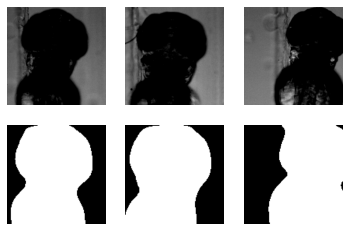

In [24]:
# sanity check

n_samples = 3

for i in range(n_samples):
    plt.subplot(2, n_samples, 1+i)
    plt.axis('off')
    plt.imshow(X_train[i], cmap='gray')
    
for i in range(n_samples):
    plt.subplot(2, n_samples, 1+n_samples+i)
    plt.axis('off')
    plt.imshow(Y_train[i])
    # plt.savefig('./pix2pix/{}.png'.format(i))
plt.show()

In [25]:
dataset = [src_images, tar_images]

In [26]:
# define the model
image_shape = src_images.shape[1:]

d_model = define_discriminator(image_shape)
g_model = define_generator(image_shape)

gan_model = define_gan(g_model, d_model, image_shape)

2022-06-22 00:18:58.381164: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1510] Created device /job:localhost/replica:0/task:0/device:GPU:0 with 30998 MB memory:  -> device: 0, name: Tesla V100-SXM2-32GB, pci bus id: 0000:61:00.0, compute capability: 7.0
/home/li52/.conda/envs/LM/lib/python3.7/site-packages/keras/optimizer_v2/optimizer_v2.py:356: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  "The `lr` argument is deprecated, use `learning_rate` instead.")


### Training

In [ ]:
from datetime import datetime
start1 = datetime.now()
trainModel(g_model, d_model, gan_model, dataset, n_epochs=TRAIN, n_batch=1)  # each epochs 512, should be 5120
stop1 = datetime.now()

2022-06-22 00:18:59.692368: I tensorflow/compiler/mlir/mlir_graph_optimization_pass.cc:185] None of the MLIR Optimization Passes are enabled (registered 2)
2022-06-22 00:19:01.711867: I tensorflow/stream_executor/cuda/cuda_dnn.cc:369] Loaded cuDNN version 8201


>1, d1[0.358] d2[0.901] g[195.783]
>2, d1[0.273] d2[1.118] g[183.597]
>3, d1[0.573] d2[0.913] g[173.852]
>4, d1[0.471] d2[0.925] g[164.692]
>5, d1[0.399] d2[0.564] g[157.890]
>6, d1[0.427] d2[0.516] g[154.625]
>7, d1[0.333] d2[0.394] g[147.483]
>8, d1[0.354] d2[0.352] g[141.617]
>9, d1[0.534] d2[0.325] g[172.400]
>10, d1[0.289] d2[0.310] g[133.703]
>11, d1[0.432] d2[0.440] g[129.458]
>12, d1[0.235] d2[0.265] g[125.885]
>13, d1[0.236] d2[0.258] g[120.962]
>14, d1[0.241] d2[0.252] g[111.112]
>15, d1[0.586] d2[0.685] g[245.050]
>16, d1[0.420] d2[0.259] g[110.299]
>17, d1[0.249] d2[0.339] g[102.736]
>18, d1[0.221] d2[0.222] g[97.572]
>19, d1[0.482] d2[0.312] g[191.412]
>20, d1[0.293] d2[0.287] g[98.745]
>21, d1[0.369] d2[0.282] g[95.179]
>22, d1[0.241] d2[0.239] g[88.479]
>23, d1[0.145] d2[0.199] g[89.557]
>24, d1[0.133] d2[0.203] g[82.952]
>25, d1[0.423] d2[0.238] g[129.122]
>26, d1[0.257] d2[0.233] g[113.455]
>27, d1[0.156] d2[0.499] g[84.295]
>28, d1[0.429] d2[0.311] g[239.869]
>29, d1[

In [ ]:
execution_time = stop1 - start1
print("Execution time is: ", execution_time)

In [ ]:
# save the model
g_model.save('./pix2pix/model_hyper/pix2pix_300eps.h5')

#### Loading the data and check the generator

In [43]:
from tensorflow.keras.models import load_model
from numpy.random import randint
from numpy import vstack

In [71]:
# loading the model
model = load_model('./pix2pix/model_hyper/model_013090.h5')

In [45]:
# plot the source, generated and target images

def plot_images(src_img, gen_img, tar_img):
    images = vstack((src_img, gen_img, tar_img))
    # scale from [-1,1] to [0,1] for visualization
    images = (images + 1) / 2.0
    titles = ['Input-segm-img', 'Output-Generated', 'Original']
    # plot images in row
    for i in range(len(images)):
        plt.subplot(1, 3, 1+i)
        plt.axis('off')
        plt.imshow(images[i,:,:,0], cmap='gray')
        plt.title(titles[i])
    plt.show()

In [72]:
gen_image = model.predict(src_test)
print(gen_image.shape)

(63, 256, 256, 3)


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


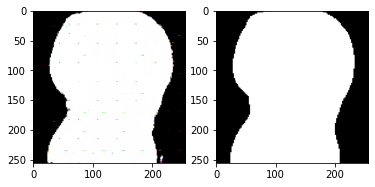

In [73]:
subShow(gen_image[0,...], tar_test[0,...])

In [59]:
# check the data shape

i = 0

tIMG = src_test[i,...]  # input
tPred = gen_image[i,...] # prediction
tMask = tar_test[i,...] # GT

print(tIMG.shape, tPred.shape, tMask.shape)

(256, 256, 3) (256, 256, 3) (256, 256, 3)


In [74]:
# document with neptune

imagePred = []

for i in range(gen_image.shape[0]):
    tIMG = src_test[i,...]  # input
    tPred = gen_image[i,...] # prediction
    tMask = tar_test[i,...] # GT
    
    bar = np.ones((tIMG.shape[0], 15))   # lines
    combTemp = np.concatenate((np.squeeze(tIMG[...,0]), bar, np.squeeze(tPred[...,0]), bar, np.squeeze(tMask[...,0])), axis=1)
    
    
    # upload the test images to neptune
    if DOCUMENT:
        # upload the test results into neptune with handle 'description'
        run["test/sample_images"].log(neptune.types.File.as_image(combTemp), name=str(i), description='test images')  
    
    imagePred.append(combTemp)
    
imagePred = np.asarray(imagePred)

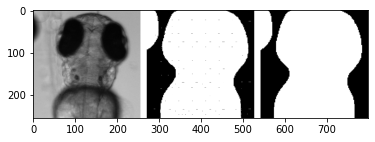

In [75]:
NUM = 19
plt.imshow(imagePred[NUM,...], cmap='gray')

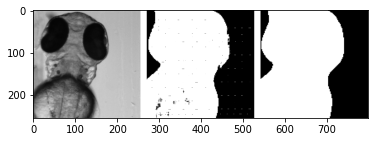

In [76]:
for i in range(imagePred.shape[0]):
    plt.imshow(imagePred[i,...], cmap='gray')
    plt.savefig('./pix2pix/val_013090/{}.png'.format(i))

In [ ]:
# [X1, X2] = dataset
# # select random example
# ix = randint(0, len(X1), 1)
# src_image, tar_image = X1[ix], X2[ix]
# # generate image from source
# gen_image = model.predict(src_image)
# # plot all three images
# plot_images(src_image, gen_image, tar_image)